In [4]:
import tensorflow as tf
tf.enable_eager_execution()

In [5]:
model = tf.keras.applications.vgg19.VGG19(include_top = False, weights = 'imagenet')

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [7]:
# max_dim = 512
def preprocessImage(image_file):
    img = tf.image.decode_image(image_file, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
#     shape = tf.cast(tf.shape(img)[:-1], dtype=tf.float32)
#     long_dim = max(shape)
#     scale = max_dim/long_dim
#     new_shape = tf.cast(shape * scale, dtype=tf.int32)
    new_shape = (224, 224)
    img = tf.image.resize(img, size=new_shape)
    img = img[tf.newaxis,:]
    return img

In [8]:
content_file = tf.read_file('turtle.jpg')
content_image = preprocessImage(content_file)

In [9]:
content_image

<tf.Tensor: id=1098, shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.        , 0.38431376, 0.48235297],
         [0.        , 0.38935578, 0.487395  ],
         [0.        , 0.39831936, 0.49635857],
         ...,
         [0.00392157, 0.41176474, 0.5176471 ],
         [0.00392157, 0.41176474, 0.5176471 ],
         [0.00392157, 0.41176474, 0.5176471 ]],

        [[0.        , 0.38711488, 0.4851541 ],
         [0.        , 0.3921569 , 0.4901961 ],
         [0.        , 0.39831936, 0.49635857],
         ...,
         [0.00392157, 0.41176474, 0.5176471 ],
         [0.00392157, 0.41176474, 0.5176471 ],
         [0.00392157, 0.41176474, 0.5176471 ]],

        [[0.        , 0.39383757, 0.49187678],
         [0.        , 0.39655867, 0.49459788],
         [0.        , 0.40000004, 0.49803925],
         ...,
         [0.00392157, 0.41176474, 0.5176471 ],
         [0.00392157, 0.41176474, 0.5176471 ],
         [0.00392157, 0.41176474, 0.5176471 ]],

        ...,

        [[0.7602244 , 0.6

In [10]:
style_file = tf.read_file('kandinsky.jpg')
style_image = preprocessImage(style_file)

In [11]:
style_image

<tf.Tensor: id=1128, shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.5254902 , 0.27058825, 0.20000002],
         [0.622409  , 0.32254905, 0.21330534],
         [0.570028  , 0.26358545, 0.11120448],
         ...,
         [0.15224132, 0.40000004, 0.5497195 ],
         [0.14621678, 0.35882235, 0.50924337],
         [0.146077  , 0.373528  , 0.5581223 ]],

        [[0.89073884, 0.66486347, 0.47899163],
         [0.90801513, 0.6421725 , 0.4803378 ],
         [0.9682624 , 0.65950507, 0.52855647],
         ...,
         [0.1237962 , 0.36868024, 0.53191715],
         [0.12752596, 0.3356494 , 0.5009887 ],
         [0.12063926, 0.3402471 , 0.52876294]],

        [[0.79061633, 0.31771713, 0.14306726],
         [0.74387383, 0.34338865, 0.20686904],
         [0.7600366 , 0.42711592, 0.3196579 ],
         ...,
         [0.16202125, 0.38834792, 0.56562746],
         [0.14614847, 0.35111827, 0.5336887 ],
         [0.1296951 , 0.34251022, 0.5273868 ]],

        ...,

        [[0.3271166 , 0.5

In [12]:
dump = tf.Variable(content_image)

In [13]:
import matplotlib.pyplot as plt

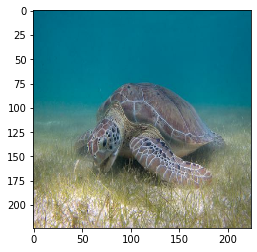

In [14]:
plt.imshow(dump.read_value()[0])

In [15]:
temp = tf.Variable(style_image)

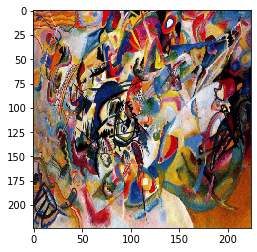

In [16]:
plt.imshow(temp.read_value()[0])

In [17]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [18]:
num_of_content_layers = len(content_layers)
num_of_style_layers = len(style_layers)

In [19]:
def getModel(layers):
    vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(layer).output for layer in layers]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [20]:
style_extractor = getModel(style_layers)

In [21]:
preprocessed_style_input = tf.keras.applications.vgg19.preprocess_input(style_image*255)

In [22]:
# preprocessed_style_input = style_image

In [23]:
style_image_output = style_extractor(preprocessed_style_input)

In [24]:
def gramMatrix(feature_map):
    gram_matrix = tf.linalg.einsum('bijc,bijd->bcd', feature_map, feature_map)
    shape = tf.shape(feature_map)
    gram_matrix = gram_matrix / tf.cast(shape[1]*shape[2], dtype=tf.float32)
    return gram_matrix

In [25]:
style_gram_matrices = [gramMatrix(style_output) for style_output in style_image_output]

In [26]:
for each in style_gram_matrices:
    print("Max: ", each.numpy().max())
    print("Min: ", each.numpy().min())
    print("Mean: ", each.numpy().mean())

Max:  13304.666
Min:  0.21836442
Mean:  1128.7397
Max:  610388.44
Min:  0.0
Mean:  46088.957
Max:  2627535.5
Min:  0.0
Mean:  63364.59
Max:  35923690.0
Min:  0.0
Mean:  691849.0
Max:  397002.5
Min:  0.0
Mean:  3913.6157


In [27]:
content_extractor = getModel(content_layers)

In [28]:
preprocessed_content_image = tf.keras.applications.vgg19.preprocess_input(content_image*255)

In [29]:
# preprocessed_content_image = content_image

In [30]:
content_image_output = content_extractor(preprocessed_content_image)

In [31]:
content_image_output

<tf.Tensor: id=2509, shape=(1, 14, 14, 512), dtype=float32, numpy=
array([[[[  0.        ,   0.        , 150.58829   , ...,   0.        ,
           77.69403   ,  35.235626  ],
         [ 20.529446  ,   0.        ,  16.827995  , ...,   0.        ,
          111.40661   ,   0.        ],
         [ 12.866628  ,   0.        ,   0.1588424 , ...,   0.        ,
          110.85342   ,   7.6848726 ],
         ...,
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
           98.28574   ,   0.        ],
         [  0.        ,   0.        ,  27.09328   , ...,   0.        ,
           81.44731   ,   0.        ],
         [  0.        ,   0.        ,  11.701914  , ...,   0.        ,
           72.20896   ,   0.        ]],

        [[  0.        ,   0.        , 155.93849   , ...,   0.        ,
            0.        ,  12.168672  ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,

In [27]:
output_image = tf.Variable(content_image)
    

In [28]:
def getReqImageOutputs(preprocessed_output_image):
    output_content_image = content_extractor(preprocessed_output_image)
    output_style_image = style_extractor(preprocessed_output_image)
    return output_content_image, output_style_image

In [29]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.02, beta1=0.99, epsilon=1e-1)

In [30]:
style_weight = 1e-2
content_weight = 1e4
def getLoss(output_content_image, output_style_gram_matrices):
    L_content = tf.add_n([tf.reduce_mean(tf.square(content_image_output[layer]-output_content_image[layer])) for layer in range(num_of_content_layers)])
    L_style = tf.add_n([tf.reduce_mean(tf.square(style_gram_matrices[layer]-output_style_gram_matrices[layer])) for layer in range(num_of_style_layers)])
    L_content = L_content * (content_weight/num_of_content_layers)
#     L_content = L_content * (content_weight)
    L_style = L_style * (style_weight/num_of_style_layers)
#     L_style = L_style * (style_weight)
    total_loss = L_content + L_style
    return total_loss

In [31]:
def train(output_image):
    with tf.GradientTape() as tape:
        preprocessed_output_image = tf.keras.applications.vgg19.preprocess_input(output_image * 255)
#         preprocessed_output_image = output_image
        output_content_image, output_style_image = getReqImageOutputs(preprocessed_output_image)
        output_style_gram_matrices = [gramMatrix(layer) for layer in output_style_image]
        loss = getLoss(output_content_image, output_style_gram_matrices)
    output_gradient = tape.gradient(loss, output_image)
    optimizer.apply_gradients([(output_gradient, output_image)])
    return loss

In [32]:
# train(output_image)

In [33]:
# train(output_image)

In [34]:
# train(output_image)

In [35]:
num_of_epochs = 10
num_of_steps = 100

In [36]:
for i in range(num_of_epochs):
    print("Epoch: ", i+1)
    for j in range(num_of_steps):
        loss = train(output_image)
        print("Step: {}, loss= {}".format(j+1, loss))

Epoch:  1
Step: 1, loss= 2843278592.0
Step: 2, loss= 2322154240.0
Step: 3, loss= 1747000832.0
Step: 4, loss= 1267101568.0
Step: 5, loss= 922701440.0
Step: 6, loss= 713337408.0
Step: 7, loss= 592751232.0
Step: 8, loss= 521719904.0
Step: 9, loss= 482493568.0
Step: 10, loss= 460979904.0
Step: 11, loss= 446652512.0
Step: 12, loss= 432927552.0
Step: 13, loss= 416035456.0
Step: 14, loss= 393554624.0
Step: 15, loss= 365161440.0
Step: 16, loss= 334150784.0
Step: 17, loss= 303962432.0
Step: 18, loss= 277598560.0
Step: 19, loss= 255143216.0
Step: 20, loss= 235389152.0
Step: 21, loss= 217700976.0
Step: 22, loss= 202164256.0
Step: 23, loss= 189020480.0
Step: 24, loss= 178603488.0
Step: 25, loss= 170650384.0
Step: 26, loss= 164796240.0
Step: 27, loss= 160448064.0
Step: 28, loss= 156889952.0
Step: 29, loss= 153693440.0
Step: 30, loss= 150763216.0
Step: 31, loss= 148230752.0
Step: 32, loss= 146089296.0
Step: 33, loss= 144363664.0
Step: 34, loss= 142856400.0
Step: 35, loss= 141451648.0
Step: 36, loss=

Step: 2, loss= 22068284.0
Step: 3, loss= 21993160.0
Step: 4, loss= 21920298.0
Step: 5, loss= 21849436.0
Step: 6, loss= 21779772.0
Step: 7, loss= 21710230.0
Step: 8, loss= 21639730.0
Step: 9, loss= 21568482.0
Step: 10, loss= 21497300.0
Step: 11, loss= 21426956.0
Step: 12, loss= 21357848.0
Step: 13, loss= 21290504.0
Step: 14, loss= 21223752.0
Step: 15, loss= 21156200.0
Step: 16, loss= 21087564.0
Step: 17, loss= 21017940.0
Step: 18, loss= 20948518.0
Step: 19, loss= 20879580.0
Step: 20, loss= 20811266.0
Step: 21, loss= 20743468.0
Step: 22, loss= 20675988.0
Step: 23, loss= 20609598.0
Step: 24, loss= 20544828.0
Step: 25, loss= 20482208.0
Step: 26, loss= 20420760.0
Step: 27, loss= 20359492.0
Step: 28, loss= 20297298.0
Step: 29, loss= 20234028.0
Step: 30, loss= 20170668.0
Step: 31, loss= 20108288.0
Step: 32, loss= 20047296.0
Step: 33, loss= 19987974.0
Step: 34, loss= 19930254.0
Step: 35, loss= 19873650.0
Step: 36, loss= 19817782.0
Step: 37, loss= 19763336.0
Step: 38, loss= 19709868.0
Step: 39,

Step: 6, loss= 12115572.0
Step: 7, loss= 12101961.0
Step: 8, loss= 12088438.0
Step: 9, loss= 12075060.0
Step: 10, loss= 12061785.0
Step: 11, loss= 12048511.0
Step: 12, loss= 12035318.0
Step: 13, loss= 12022192.0
Step: 14, loss= 12009136.0
Step: 15, loss= 11996032.0
Step: 16, loss= 11982969.0
Step: 17, loss= 11969902.0
Step: 18, loss= 11956914.0
Step: 19, loss= 11944084.0
Step: 20, loss= 11931382.0
Step: 21, loss= 11918736.0
Step: 22, loss= 11906062.0
Step: 23, loss= 11893294.0
Step: 24, loss= 11880506.0
Step: 25, loss= 11867747.0
Step: 26, loss= 11855148.0
Step: 27, loss= 11842704.0
Step: 28, loss= 11830325.0
Step: 29, loss= 11817989.0
Step: 30, loss= 11805672.0
Step: 31, loss= 11793285.0
Step: 32, loss= 11780794.0
Step: 33, loss= 11768291.0
Step: 34, loss= 11755761.0
Step: 35, loss= 11743306.0
Step: 36, loss= 11730921.0
Step: 37, loss= 11718528.0
Step: 38, loss= 11706183.0
Step: 39, loss= 11693934.0
Step: 40, loss= 11681680.0
Step: 41, loss= 11669455.0
Step: 42, loss= 11657334.0
Step:

Step: 12, loss= 9748492.0
Step: 13, loss= 9744021.0
Step: 14, loss= 9739561.0
Step: 15, loss= 9735070.0
Step: 16, loss= 9730562.0
Step: 17, loss= 9726040.0
Step: 18, loss= 9721504.0
Step: 19, loss= 9716938.0
Step: 20, loss= 9712353.0
Step: 21, loss= 9707810.0
Step: 22, loss= 9703301.0
Step: 23, loss= 9698860.0
Step: 24, loss= 9694430.0
Step: 25, loss= 9690040.0
Step: 26, loss= 9685686.0
Step: 27, loss= 9681343.0
Step: 28, loss= 9677045.0
Step: 29, loss= 9672821.0
Step: 30, loss= 9668631.0
Step: 31, loss= 9664420.0
Step: 32, loss= 9660182.0
Step: 33, loss= 9655928.0
Step: 34, loss= 9651660.0
Step: 35, loss= 9647361.0
Step: 36, loss= 9643088.0
Step: 37, loss= 9638837.0
Step: 38, loss= 9634635.0
Step: 39, loss= 9630498.0
Step: 40, loss= 9626376.0
Step: 41, loss= 9622300.0
Step: 42, loss= 9618244.0
Step: 43, loss= 9614160.0
Step: 44, loss= 9610037.0
Step: 45, loss= 9605883.0
Step: 46, loss= 9601752.0
Step: 47, loss= 9597594.0
Step: 48, loss= 9593400.0
Step: 49, loss= 9589218.0
Step: 50, lo

In [37]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


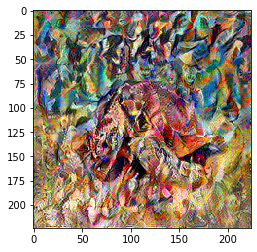

In [38]:
plt.imshow(output_image.read_value()[0])